In [1]:
#import all packages 
import pandas as pd
import warnings
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('../data/kc_house_data.csv')

In [2]:
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


In [3]:
# drop columns that have no desire to our stakeholder 
clean_null = data.drop(columns=['id','date','long','yr_built','condition','view', 'waterfront',], axis=1)


In [4]:
clean_null.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,83.636778,98077.951845,47.560093,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,399.946414,53.513072,0.138552,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,0.000000,98001.000000,47.155900,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,0.000000,98033.000000,47.471100,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,98065.000000,47.571800,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,0.000000,98118.000000,47.678000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,98199.000000,47.777600,6210.000000,871200.000000


In [5]:
# locating outliers in bedroom 
clean_null = clean_null.loc[clean_null['bedrooms'] < 8] # TODO add comments justifying these
clean_null = clean_null.loc[clean_null['bathrooms'] < 6] 
clean_null = clean_null.loc[clean_null['sqft_living'] < 6000 ]
clean_null = clean_null.loc[clean_null['price'] < 1500000 ]
clean_null = clean_null.loc[clean_null['bedrooms'] > .99]
clean_null = clean_null.loc[clean_null['bathrooms'] > .99]
clean_null = clean_null.loc[clean_null['sqft_living'] > 600 ]
clean_null = clean_null.loc[clean_null['price'] > 100000 ]
clean_null = clean_null.loc[clean_null['sqft_lot'] < 100000 ]
clean_null = clean_null.loc[clean_null['floors'] < 2.1 ]



In [6]:
clean_null = clean_null.loc[clean_null['sqft_basement'] != '?' ] 

In [7]:
clean_null['sqft_basement'] = clean_null['sqft_basement'].astype(float)

In [8]:
clean_null['true_sqft'] = clean_null['sqft_living']  - clean_null['sqft_basement']


In [9]:
# creating a new feature of price per sqft
clean_null['price_per_sqft'] = clean_null['price']  / clean_null['true_sqft']


In [10]:
test = [i[0:2].strip() for i in clean_null['grade']]


In [11]:
clean_null['grade_ordinal'] = [int(i[0:2].strip()) for i in clean_null['grade']]

In [12]:
zip_home_size = clean_null.loc[clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164])]



In [13]:
curated_zip = np.array([98052,98102,98103,98105,98109,98119,98121,98134,98164])

In [14]:

# TODO add these OHE'd columns to main data by assigning <dfname>['zipcodes_ohe']
#
# take out the isin function for all zipcodes, if that makes the OLS work. could also narrow down to curated after the OHE on all zipcodes
zips = clean_null.loc[clean_null['zipcode'].isin(curated_zip)].dropna() 
ohe = OneHotEncoder(sparse=False, drop=[98109]) # the zip code with the highest prices in Seattle. could do 98052, near the Microsoft campus as well
ohe.fit(zips['zipcode'].to_numpy().reshape(-1, 1))
zips_encoded = ohe.transform(zips['zipcode'].to_numpy().reshape(-1, 1))

zipcodes_ohe = pd.DataFrame(zips_encoded, columns=ohe.get_feature_names(), index=zips.index)

In [55]:
zip_home_size.dropna(inplace=True)

In [56]:
zip_home_size.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15,true_sqft,price_per_sqft,grade_ordinal
price,1.000000,0.378722,0.469247,0.685325,0.125141,0.357067,0.585763,0.264767,0.095900,0.133174,-0.163165,0.493543,0.087164,0.585763,0.260599,0.606296
bedrooms,0.378722,1.000000,0.493623,0.624528,0.191515,0.222276,0.499243,0.303293,0.008931,-0.229049,0.072792,0.350736,0.172175,0.499243,-0.249817,0.285390
bathrooms,0.469247,0.493623,1.000000,0.702778,0.156255,0.480868,0.570925,0.324909,0.059175,-0.276614,0.068087,0.440105,0.164057,0.570925,-0.227283,0.588613
sqft_living,0.685325,0.624528,0.702778,1.000000,0.338868,0.422347,0.857207,0.381879,0.017210,-0.325092,0.154860,0.668948,0.338078,0.857207,-0.322013,0.672554
sqft_lot,0.125141,0.191515,0.156255,0.338868,1.000000,-0.054203,0.368307,-0.010268,-0.056516,-0.481240,0.321111,0.418294,0.866998,0.368307,-0.274597,0.285603
floors,0.357067,0.222276,0.480868,0.422347,-0.054203,1.000000,0.579547,-0.229072,0.033467,-0.063000,0.032070,0.322013,-0.056093,0.579547,-0.350654,0.509747
sqft_above,0.585763,0.499243,0.570925,0.857207,0.368307,0.579547,1.000000,-0.148595,-0.026687,-0.427102,0.248689,0.702282,0.378584,1.000000,-0.561210,0.711124
sqft_basement,0.264767,0.303293,0.324909,0.381879,-0.010268,-0.229072,-0.148595,1.000000,0.080943,0.142242,-0.148941,0.024202,-0.030230,-0.148595,0.388833,0.015260
yr_renovated,0.095900,0.008931,0.059175,0.017210,-0.056516,0.033467,-0.026687,0.080943,1.000000,0.125922,-0.052073,-0.061129,-0.053216,-0.026687,0.114789,0.006131
zipcode,0.133174,-0.229049,-0.276614,-0.325092,-0.481240,-0.063000,-0.427102,0.142242,0.125922,1.000000,-0.425723,-0.477051,-0.534242,-0.427102,0.608542,-0.314914


In [69]:
zip_new_columns = zip_home_size.drop(columns=['zipcode','grade','price_per_sqft','sqft_lot15','sqft_lot','sqft_above'], axis=1)
# zip_new_columns.reset_index(inplace=True, drop=True)
zip_new_columns.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15', 'true_sqft',
       'grade_ordinal'],
      dtype='object')

In [70]:
zip_new_columns.head()

,price,bedrooms,bathrooms,sqft_living,floors,sqft_basement,yr_renovated,lat,sqft_living15,true_sqft,grade_ordinal
17,485000.0,4,1.00,1600,1.5,0.0,0.0,47.6648,1610,1600.0,7
29,719000.0,4,2.50,2570,2.0,0.0,0.0,47.7073,2630,2570.0,8
36,550000.0,4,1.00,1660,1.0,730.0,0.0,47.6621,2160,930.0,5
43,685000.0,3,1.00,1570,2.0,0.0,0.0,47.6413,1580,1570.0,7
54,920000.0,5,2.25,2730,1.5,600.0,0.0,47.6571,2730,2130.0,8


In [71]:
X = zip_new_columns.drop(['price'], axis=1)
ss = StandardScaler().fit(X)
znc_scaled = pd.DataFrame(ss.transform(X), columns=X.columns).dropna() # adding standard scalar to only zip_new_columns, abbreviated as znc

In [72]:
# concatenating two dataframes, znc_scaled and the one hot encoded zipcodes zipcodes_ohe 
zip_ohe_columns = pd.merge(znc_scaled , zipcodes_ohe, how='outer', left_index=True, right_on=znc_scaled.index) #pd.concat([znc_scaled , zipcodes_ohe], axis=1) 
zip_ohe_columns = zip_ohe_columns.drop('key_0', axis=1)
zip_ohe_columns

,bedrooms,bathrooms,sqft_living,floors,sqft_basement,yr_renovated,lat,sqft_living15,true_sqft,grade_ordinal,x0_98052,x0_98102,x0_98103,x0_98105,x0_98119
17,0.711173,-1.445351,-0.552812,-0.024816,-0.818850,-0.231864,-0.159487,-0.590374,-0.135239,-0.766260,0.0,0.0,1.0,0.0,0.0
29,0.711173,0.578542,0.726570,1.097626,-0.818850,-0.231864,1.550071,1.155694,1.233687,0.242835,1.0,0.0,0.0,0.0,0.0
36,0.711173,-1.445351,-0.473675,-1.147258,1.030073,-0.231864,-0.268094,0.351134,-1.080786,-2.784450,1.0,0.0,0.0,0.0,0.0
43,-0.350171,-1.445351,-0.592380,1.097626,-0.818850,-0.231864,-1.104772,-0.641729,-0.177577,-0.766260,0.0,0.0,0.0,0.0,1.0
54,1.772517,0.241227,0.937602,-0.024816,0.700813,-0.231864,-0.469219,1.326877,0.612731,0.242835,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21480,0.711173,0.578542,1.346477,1.097626,-0.818850,-0.231864,0.403662,1.857545,1.896982,0.242835,1.0,0.0,0.0,0.0,0.0
21499,0.711173,0.578542,2.045521,1.097626,-0.818850,-0.231864,1.441464,2.182793,2.644952,1.251930,1.0,0.0,0.0,0.0,0.0
21550,0.711173,1.253173,-0.460485,1.097626,-0.008363,-0.231864,-1.169132,-0.487664,-0.488055,0.242835,0.0,0.0,0.0,0.0,0.0
21563,-0.350171,1.590489,-0.381348,1.097626,0.219587,-0.231864,-1.261649,-0.419191,-0.530393,1.251930,0.0,0.0,0.0,0.0,1.0


In [73]:
# zip_ohe_columns = zip_ohe_columns.dropna() # don't need to do this because NaNs were dropped above

In [74]:
#zip_ohe_columns = zip_ohe_columns.drop(columns=['x0_98102',
      # 'x0_98103', 'x0_98105', 'x0_98119'], axis=1)
#zip_new_columns.reset_index(inplace=True, drop=True)

In [75]:
zip_ohe_columns.corr()

,bedrooms,bathrooms,sqft_living,floors,sqft_basement,yr_renovated,lat,sqft_living15,true_sqft,grade_ordinal,x0_98052,x0_98102,x0_98103,x0_98105,x0_98119
bedrooms,1.000000,0.493623,0.624528,0.222276,0.303293,0.008931,0.072792,0.350736,0.499243,0.285390,0.235234,-0.073790,-0.187997,0.050949,-0.059823
bathrooms,0.493623,1.000000,0.702778,0.480868,0.324909,0.059175,0.068087,0.440105,0.570925,0.588613,0.296438,-0.015984,-0.286733,0.001076,-0.004338
sqft_living,0.624528,0.702778,1.000000,0.422347,0.381879,0.017210,0.154860,0.668948,0.857207,0.672554,0.336784,-0.056268,-0.265538,0.000490,-0.066366
floors,0.222276,0.480868,0.422347,1.000000,-0.229072,0.033467,0.032070,0.322013,0.579547,0.509747,0.076916,0.122495,-0.155047,-0.018160,0.056387
sqft_basement,0.303293,0.324909,0.381879,-0.229072,1.000000,0.080943,-0.148941,0.024202,-0.148595,0.015260,-0.136416,0.020974,-0.006000,0.108672,0.067650
yr_renovated,0.008931,0.059175,0.017210,0.033467,0.080943,1.000000,-0.052073,-0.061129,-0.026687,0.006131,-0.117832,-0.029869,0.049510,0.022627,0.080630
lat,0.072792,0.068087,0.154860,0.032070,-0.148941,-0.052073,1.000000,0.176397,0.248689,0.073714,0.373242,-0.281237,0.177791,-0.048985,-0.360898
sqft_living15,0.350736,0.440105,0.668948,0.322013,0.024202,-0.061129,0.176397,1.000000,0.702282,0.643093,0.497986,-0.026765,-0.422183,-0.028636,-0.078747
true_sqft,0.499243,0.570925,0.857207,0.579547,-0.148595,-0.026687,0.248689,0.702282,1.000000,0.711124,0.436367,-0.071893,-0.280780,-0.060028,-0.108705
grade_ordinal,0.285390,0.588613,0.672554,0.509747,0.015260,0.006131,0.073714,0.643093,0.711124,1.000000,0.342176,0.017149,-0.364180,-0.023257,0.009958


In [76]:
zip_ohe_columns.columns


Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_basement',
       'yr_renovated', 'lat', 'sqft_living15', 'true_sqft', 'grade_ordinal',
       'x0_98052', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98119'],
      dtype='object')

In [77]:

y = zip_new_columns['price']
x = zip_ohe_columns['sqft_living']
X_c = sm.add_constant(x)


simple_model = sm.OLS(y, X_c)


simple_model_results = simple_model.fit()
print(simple_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     1040.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          6.90e-164
Time:                        16:05:08   Log-Likelihood:                -15803.
No. Observations:                1176   AIC:                         3.161e+04
Df Residuals:                    1174   BIC:                         3.162e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.733e+05   4839.234    139.126      

In [78]:
zip_new_columns.describe()

,price,bedrooms,bathrooms,sqft_living,floors,sqft_basement,yr_renovated,lat,sqft_living15,true_sqft,grade_ordinal
count,1.176000e+03,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,6.732621e+05,3.329932,2.071216,2019.130102,1.511054,323.301871,101.886054,47.668765,1954.878401,1695.828231,7.759354
std,2.277837e+05,0.942602,0.741461,758.500984,0.445647,394.992386,439.608236,0.024871,584.418244,708.885972,0.991409
min,2.166500e+05,1.000000,1.000000,630.000000,1.000000,0.000000,0.000000,47.542000,690.000000,600.000000,5.000000
25%,5.147500e+05,3.000000,1.500000,1440.000000,1.000000,0.000000,0.000000,47.650075,1550.000000,1160.000000,7.000000
50%,6.352500e+05,3.000000,2.000000,1920.000000,1.500000,20.000000,0.000000,47.667700,1830.000000,1520.000000,8.000000
75%,7.800000e+05,4.000000,2.500000,2500.000000,2.000000,620.000000,0.000000,47.687200,2252.500000,2040.000000,8.000000
max,1.490000e+06,7.000000,4.500000,4980.000000,2.000000,1900.000000,2014.000000,47.731800,4280.000000,4750.000000,12.000000


In [79]:
#reviewing coef and p value significants 
y = zip_new_columns['price']
X = zip_ohe_columns
y = y.dropna()
X = X.dropna()

# len(y), len(X)
ols_kch = sm.OLS(y, sm.add_constant(X)).fit()
ols_kch.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     203.9
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          9.74e-301
Time:                        16:05:10   Log-Likelihood:                -15446.
No. Observations:                1176   AIC:                         3.092e+04
Df Residuals:                    1161   BIC:                         3.100e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.622e+05    1.6e+04     47.544      0.000    7.31e+05    7.94e+05
bedrooms       3328.4670   4842.099      0.687      0.492   -6171.776    1.28e+04
bathrooms     -2226.7970   5840.067     -0.381      0.703   -1.37e+04    9231.470
sqft_living     6.98e+04   3941.200     17.710      0.000    6.21e+04    7.75e+04
floors        -2.001e+04   5259.465     -3.805      0.000   -3.03e+04   -9693.488
sqft_basement  1.619e+04   4132.349      3.918      0.000    8083.472    2.43e+04
yr_renovated   9716.1737   3651.255      2.661      0.008    2552.376    1.69e+04
lat           -2.997e+04   4781.371     -6.268      0.000   -3.94e+04   -2.06e+04
sqft_living15  3.797e+04   5796.955      6.550      0.000    2.66e+04    4.93e+04
true_sqft      6.566e+04   4285.201     15.323      0.000    5.73e+04    7.41e+04
grade_ordinal  6.455e+04   5939.092     10.869      0.000    5.29e+04    7.62e+04
x0_98052       -2.19e+05   1.85e+04    -11.824      0.000   -2.55e+05   -1.83e+05
x0_98102      -2.231e+04    2.3e+04     -0.970      0.332   -6.75e+04    2.28e+04
x0_98103       -2.67e+04   1.81e+04     -1.473      0.141   -6.23e+04    8866.441
x0_98105       1.074e+04   1.86e+04      0.576      0.565   -2.58e+04    4.73e+04
x0_98119       1.468e+04   1.87e+04      0.785      0.433    -2.2e+04    5.14e+04
==============================================================================
Omnibus:                      141.795   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.704
Skew:                           0.543   Prob(JB):                    3.13e-114
Kurtosis:                       6.080   Cond. No.                     7.20e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.01e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [80]:
#identifying the lots we recommend the stakeholder purchase and build new multifamily homes. 

zip_lot_size = clean_null.loc[(clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164]))
                              & (clean_null['sqft_lot'] >= 40000)]

zip_lot_size

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15,true_sqft,price_per_sqft,grade_ordinal
340,485000.0,4,1.75,2560,43995,2.0,7 Average,2560,0.0,0.0,98052,47.6945,2560,14764,2560.0,189.453125,7
2580,965000.0,4,2.50,4070,57587,2.0,10 Very Good,4070,0.0,0.0,98052,47.6908,3890,35960,4070.0,237.100737,10
2956,900000.0,4,2.50,3620,42580,2.0,10 Very Good,3620,0.0,0.0,98052,47.7204,2950,33167,3620.0,248.618785,10
3671,620000.0,3,2.25,2190,45738,1.0,8 Good,2190,0.0,0.0,98052,47.7108,2970,4496,2190.0,283.105023,8
3716,735000.0,6,2.75,3360,84506,1.0,7 Average,2040,1320.0,0.0,98052,47.7150,2190,43124,2040.0,360.294118,7
4470,1050000.0,3,4.00,4380,42769,2.0,11 Excellent,4380,0.0,0.0,98052,47.7167,3630,35425,4380.0,239.726027,11
5302,1120000.0,4,3.25,4750,62365,2.0,11 Excellent,4750,0.0,0.0,98052,47.7149,3300,31866,4750.0,235.789474,11
6024,822000.0,4,2.50,2683,40386,2.0,9 Better,2683,0.0,0.0,98052,47.6982,2683,34800,2683.0,306.373463,9
6578,550000.0,3,2.25,1980,40887,1.0,8 Good,1980,0.0,NaN,98052,47.6478,2460,35700,1980.0,277.777778,8
9829,830000.0,4,2.50,1850,50662,1.0,8 Good,1430,420.0,0.0,98052,47.6535,2090,10599,1430.0,580.419580,8


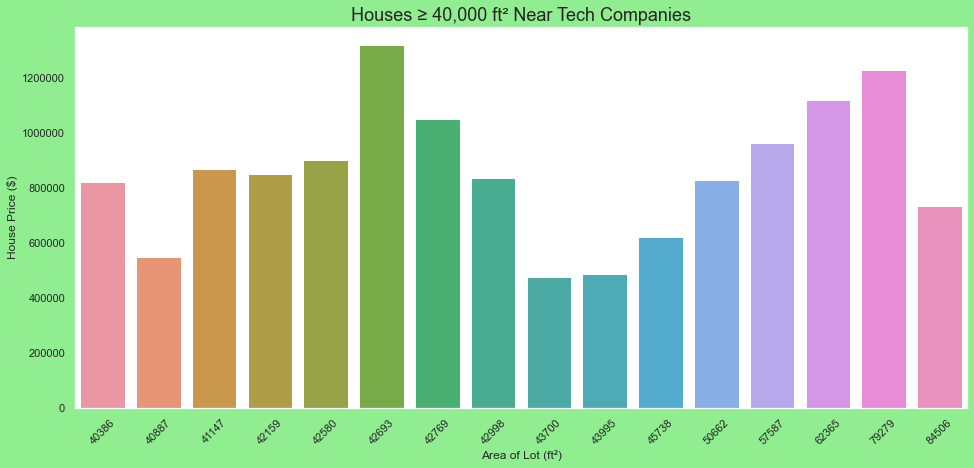

In [81]:

fig, ax = plt.subplots(figsize=(16,7))

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'lightgreen'})
sns.barplot(data=zip_lot_size, x='sqft_lot', y='price');

# plt.bar(data=zip_lot_size, x='sqft_living', height='price')
plt.title('Houses ≥ 40,000 ft² Near Tech Companies', fontsize=18)
plt.xlabel('Area of Lot (ft²)')
plt.ylabel('House Price ($)')
plt.xticks(rotation=45)
# plt.yticks(labels=((zip_lot_size['price'])/100))
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()


x 1 scaled and not scaled (x)
b4 1hot and after 

In [82]:
zip_ohe_columns.shape

(1176, 15)

In [83]:
#Linearity
# X = zip_ohe_columns.drop(['price'], axis=1)
# ss = StandardScaler().fit(X)

# X_scaled = ss.transform(X)

In [84]:
X_c = sm.add_constant(zip_ohe_columns.drop(['price'], axis=1))
y = zip_ohe_columns['price']

KeyError: "['price'] not found in axis"

In [85]:
clean_null.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15,true_sqft,price_per_sqft,grade_ordinal
count,1.933000e+04,19330.000000,19330.000000,19330.000000,19330.000000,19330.000000,19330.000000,19330.000000,15903.000000,19330.000000,19330.000000,19330.000000,19330.000000,19330.000000,19330.000000,19330.000000
mean,4.966426e+05,3.363735,2.064356,2017.648681,10435.422400,1.433963,1731.792757,285.855923,77.566748,98077.885256,47.557434,1958.424573,10127.079359,1731.792757,306.688580,7.571340
std,2.446920e+05,0.867900,0.716011,799.684615,11277.372053,0.471960,745.738627,422.309377,385.782083,53.919354,0.139746,644.479240,13623.290345,745.738627,138.025624,1.075651
min,1.049500e+05,1.000000,1.000000,610.000000,520.000000,1.000000,480.000000,0.000000,0.000000,98001.000000,47.155900,399.000000,651.000000,480.000000,87.588235,4.000000
25%,3.150000e+05,3.000000,1.500000,1420.000000,5133.750000,1.000000,1180.000000,0.000000,0.000000,98033.000000,47.464300,1490.000000,5200.000000,1180.000000,202.330124,7.000000
50%,4.400000e+05,3.000000,2.000000,1900.000000,7598.000000,1.000000,1540.000000,0.000000,0.000000,98065.000000,47.567000,1830.000000,7620.000000,1540.000000,275.124823,7.000000
75%,6.200000e+05,4.000000,2.500000,2480.000000,10275.750000,2.000000,2140.000000,560.000000,0.000000,98118.000000,47.678600,2320.000000,9861.000000,2140.000000,382.758621,8.000000
max,1.490000e+06,7.000000,5.750000,5960.000000,99916.000000,2.000000,5844.000000,2850.000000,2015.000000,98199.000000,47.777600,5790.000000,392040.000000,5844.000000,1336.206897,12.000000


In [37]:
3.3 + .86

4.16

In [31]:
model = sm.OLS(endog=y, exog=X_c).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     203.9
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          9.74e-301
Time:                        15:34:22   Log-Likelihood:                -958.28
No. Observations:                1176   AIC:                             1947.
Df Residuals:                    1161   BIC:                             2023.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3974      0.071      5.561      0.000       0.257       0.538
bedrooms          0.0150      0.022      0.687      0.492      -0.028       0.058
bathrooms        -0.0098      0.026     -0.381      0.703      -0.061       0.041
sqft_living       0.2315      0.013     17.265      0.000       0.205       0.258
floors           -0.0897      0.024     -3.805      0.000      -0.136      -0.043
sqft_above        0.1834      0.012     15.309      0.000       0.160       0.207
sqft_basement     0.1130      0.018      6.358      0.000       0.078       0.148
yr_renovated      0.0434      0.016      2.661      0.008       0.011       0.075
lat              -0.1348      0.022     -6.268      0.000      -0.177      -0.093
sqft_living15     0.1703      0.026      6.550      0.000       0.119       0.221
true_sqft         0.1834      0.012     15.309      0.000       0.160       0.207
grade_ordinal     0.2876      0.026     10.869      0.000       0.236       0.340
x0_98052         -0.9778      0.083    -11.824      0.000      -1.140      -0.816
x0_98102         -0.0996      0.103     -0.970      0.332      -0.301       0.102
x0_98103         -0.1192      0.081     -1.473      0.141      -0.278       0.040
x0_98105          0.0480      0.083      0.576      0.565      -0.115       0.211
x0_98119          0.0656      0.084      0.785      0.433      -0.098       0.229
==============================================================================
Omnibus:                      141.795   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.704
Skew:                           0.543   Prob(JB):                    3.13e-114
Kurtosis:                       6.080   Cond. No.                     3.89e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.13e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

NameError: name 'a' is not defined

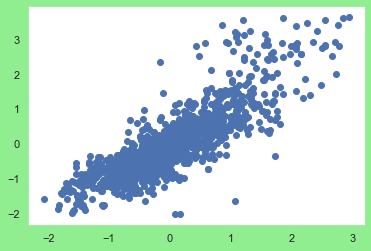

In [32]:
model_preds = model.predict(X_c)
resids = y - model_preds

fig, ax = plt.subplots()

# add R2

ax.scatter(model_preds, y)
ax.plot(model_preds, a + b * model_preds, color="red", lw=2.5, alpha=0.7) # Plot regression line
b, a = np.polyfit(model_preds, y, deg=1)
R2 = ax.scatter([0.711],[0.711], color='black', marker='D', s=65 )
ax.legend(('Predicted', 'Actual', 'R²'), loc="upper left")
# ax.add_artist(legend)
ax.set_xlabel('Predicted Home Prices')
ax.set_ylabel('Actual Home Prices')
plt.suptitle('Actual Vs. Predicted')
plt.show();

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))


ax.scatter(X['bathrooms'], y)
ax.set_title('Home Price Price vs. bath');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

In [ ]:
dw = sm.stats.stattools.durbin_watson

In [ ]:
dw(resids)

In [ ]:
model.summary().tables[2]

In [ ]:
resids.hist(bins=50);

In [ ]:
sm.qqplot(resids, line='r');

In [ ]:
zip_ohe_columns.info()

In [ ]:
zip_ohe_columns['grade_ordinal'].unique()

In [ ]:
fig, ax = plt.subplots()

ax.scatter(y=zip_ohe_columns['price'], x=zip_ohe_columns.drop(['price'], axis=1));

In [ ]:
model.summary().tables[2]

In [ ]:
y.hist();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

In [ ]:
y_log = np.log(y)
y_log.hist();

In [ ]:
# 'x1' is 
sm.graphics.plot_regress_exog(model, 'x1', fig=plt.figure(figsize=(12, 8)));